# Method 8 - Best Ideas Low Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[best_ideas['herf_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

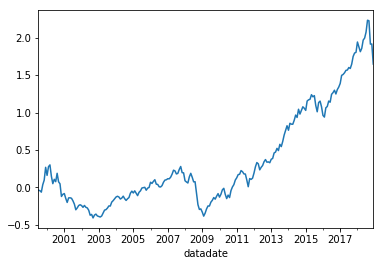

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.268282
2000-12-31   -0.284226
2001-12-31   -0.153419
2002-12-31   -0.194865
2003-12-31    0.368878
2004-12-31    0.121280
2005-12-31    0.052447
2006-12-31    0.102484
2007-12-31    0.083948
2008-12-31   -0.403117
2009-12-31    0.285512
2010-12-31    0.198813
2011-12-31    0.022068
2012-12-31    0.184101
2013-12-31    0.371529
2014-12-31    0.128090
2015-12-31    0.009597
2016-12-31    0.126832
2017-12-31    0.198131
2018-12-31   -0.055793
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     579.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.74e-118
Time:                        06:19:07   Log-Likelihood:                 660.82
No. Observations:                 234   AIC:                            -1312.
Df Residuals:                     229   BIC:                            -1294.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.392      0.695      -0.002       0.002
mktrf          1.0271      0.027     37.925      0.000       0.974       1.080
me             0.1968      0.032      6.248      0.000       0.135       0.259
ia            -0.2933      0.048     -6.126      0.000      -0.388      -0.199
roe            0.1828      0.041      4.460      0.000       0.102       0.264
==============================================================================
Omnibus:                       20.862   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.413
Skew:                           0.012   Prob(JB):                     2.10e-18
Kurtosis:                       5.890   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     222.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.05e-77
Time:                        06:19:07   Log-Likelihood:                 660.82
No. Observations:                 234   AIC:                            -1312.
Df Residuals:                     229   BIC:                            -1294.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.438      0.662      -0.001       0.002
mktrf          1.0271      0.037     28.024      0.000       0.955       1.099
me             0.1968      0.036      5.458      0.000       0.126       0.267
ia            -0.2933      0.092     -3.183      0.001      -0.474      -0.113
roe            0.1828      0.042      4.393      0.000       0.101       0.264
==============================================================================
Omnibus:                       20.862   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.413
Skew:                           0.012   Prob(JB):                     2.10e-18
Kurtosis:                       5.890   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     237.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.26e-80
Time:                        06:19:07   Log-Likelihood:                 660.82
No. Observations:                 234   AIC:                            -1312.
Df Residuals:                     229   BIC:                            -1294.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.462      0.644      -0.001       0.002
mktrf          1.0271      0.037     27.509      0.000       0.954       1.100
me             0.1968      0.036      5.429      0.000       0.126       0.268
ia            -0.2933      0.085     -3.463      0.001      -0.459      -0.127
roe            0.1828      0.039      4.652      0.000       0.106       0.260
==============================================================================
Omnibus:                       20.862   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.413
Skew:                           0.012   Prob(JB):                     2.10e-18
Kurtosis:                       5.890   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     439.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.37e-115
Time:                        06:19:07   Log-Likelihood:                 655.72
No. Observations:                 234   AIC:                            -1299.
Df Residuals:                     228   BIC:                            -1279.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.811      0.418      -0.001       0.003
mktrf          0.9987      0.028     35.932      0.000       0.944       1.053
smb            0.2030      0.037      5.537      0.000       0.131       0.275
hml           -0.1756      0.043     -4.061      0.000      -0.261      -0.090
rmw            0.0903      0.049      1.847      0.066      -0.006       0.187
cma           -0.1147      0.062     -1.845      0.066      -0.237       0.008
==============================================================================
Omnibus:                       16.094   Durbin-Watson:                   2.223
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.082
Skew:                           0.248   Prob(JB):                     5.38e-09
Kurtosis:                       4.913   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     307.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.54e-99
Time:                        06:19:07   Log-Likelihood:                 655.72
No. Observations:                 234   AIC:                            -1299.
Df Residuals:                     228   BIC:                            -1279.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.949      0.342      -0.001       0.003
mktrf          0.9987      0.034     29.644      0.000       0.933       1.065
smb            0.2030      0.044      4.630      0.000       0.117       0.289
hml           -0.1756      0.063     -2.783      0.005      -0.299      -0.052
rmw            0.0903      0.062      1.448      0.148      -0.032       0.213
cma           -0.1147      0.114     -1.002      0.316      -0.339       0.110
==============================================================================
Omnibus:                       16.094   Durbin-Watson:                   2.223
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.082
Skew:                           0.248   Prob(JB):                     5.38e-09
Kurtosis:                       4.913   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     327.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.34e-102
Time:                        06:19:07   Log-Likelihood:                 655.72
No. Observations:                 234   AIC:                            -1299.
Df Residuals:                     228   BIC:                            -1279.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.032      0.302      -0.001       0.002
mktrf          0.9987      0.037     27.285      0.000       0.927       1.070
smb            0.2030      0.044      4.645      0.000       0.117       0.289
hml           -0.1756      0.064     -2.735      0.006      -0.301      -0.050
rmw            0.0903      0.063      1.426      0.154      -0.034       0.214
cma           -0.1147      0.110     -1.043      0.297      -0.330       0.101
==============================================================================
Omnibus:                       16.094   Durbin-Watson:                   2.223
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.082
Skew:                           0.248   Prob(JB):                     5.38e-09
Kurtosis:                       4.913   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     772.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.26e-131
Time:                        06:19:07   Log-Likelihood:                 691.76
No. Observations:                 234   AIC:                            -1374.
Df Residuals:                     229   BIC:                            -1356.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.381e-06      0.001      0.008      0.994      -0.002       0.002
mktrf          1.0771      0.022     49.304      0.000       1.034       1.120
smb            0.0942      0.027      3.453      0.001       0.040       0.148
hml           -0.1205      0.027     -4.449      0.000      -0.174      -0.067
umd            0.1718      0.018      9.668      0.000       0.137       0.207
==============================================================================
Omnibus:                        7.883   Durbin-Watson:                   2.109
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               10.777
Skew:                          -0.226   Prob(JB):                      0.00457
Kurtosis:                       3.949   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     912.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.14e-139
Time:                        06:19:07   Log-Likelihood:                 691.76
No. Observations:                 234   AIC:                            -1374.
Df Residuals:                     229   BIC:                            -1356.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.381e-06      0.001      0.009      0.993      -0.001       0.001
mktrf          1.0771      0.038     28.298      0.000       1.003       1.152
smb            0.0942      0.040      2.334      0.020       0.015       0.173
hml           -0.1205      0.033     -3.602      0.000      -0.186      -0.055
umd            0.1718      0.033      5.232      0.000       0.107       0.236
==============================================================================
Omnibus:                        7.883   Durbin-Watson:                   2.109
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               10.777
Skew:                          -0.226   Prob(JB):                      0.00457
Kurtosis:                       3.949   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     1071.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.57e-147
Time:                        06:19:08   Log-Likelihood:                 691.76
No. Observations:                 234   AIC:                            -1374.
Df Residuals:                     229   BIC:                            -1356.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.381e-06      0.001      0.011      0.992      -0.001       0.001
mktrf          1.0771      0.043     25.009      0.000       0.993       1.162
smb            0.0942      0.044      2.158      0.031       0.009       0.180
hml           -0.1205      0.031     -3.951      0.000      -0.180      -0.061
umd            0.1718      0.032      5.398      0.000       0.109       0.234
==============================================================================
Omnibus:                        7.883   Durbin-Watson:                   2.109
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               10.777
Skew:                          -0.226   Prob(JB):                      0.00457
Kurtosis:                       3.949   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     258.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.66e-56
Time:                        06:19:08   Log-Likelihood:                 317.32
No. Observations:                 120   AIC:                            -624.6
Df Residuals:                     115   BIC:                            -610.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.002     -0.471      0.639      -0.004       0.003
mktrf          1.0606      0.045     23.431      0.000       0.971       1.150
me             0.2396      0.045      5.360      0.000       0.151       0.328
ia            -0.3308      0.070     -4.725      0.000      -0.469      -0.192
roe            0.2528      0.062      4.080      0.000       0.130       0.376
==============================================================================
Omnibus:                       10.337   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               24.939
Skew:                           0.113   Prob(JB):                     3.84e-06
Kurtosis:                       5.222   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     82.28
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.91e-33
Time:                        06:19:08   Log-Likelihood:                 317.32
No. Observations:                 120   AIC:                            -624.6
Df Residuals:                     115   BIC:                            -610.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.566      0.572      -0.004       0.002
mktrf          1.0606      0.066     15.991      0.000       0.931       1.191
me             0.2396      0.043      5.597      0.000       0.156       0.324
ia            -0.3308      0.120     -2.747      0.006      -0.567      -0.095
roe            0.2528      0.052      4.882      0.000       0.151       0.354
==============================================================================
Omnibus:                       10.337   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               24.939
Skew:                           0.113   Prob(JB):                     3.84e-06
Kurtosis:                       5.222   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     74.94
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.95e-31
Time:                        06:19:08   Log-Likelihood:                 317.32
No. Observations:                 120   AIC:                            -624.6
Df Residuals:                     115   BIC:                            -610.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.609      0.543      -0.003       0.002
mktrf          1.0606      0.068     15.709      0.000       0.928       1.193
me             0.2396      0.042      5.700      0.000       0.157       0.322
ia            -0.3308      0.113     -2.916      0.004      -0.553      -0.108
roe            0.2528      0.041      6.225      0.000       0.173       0.332
==============================================================================
Omnibus:                       10.337   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               24.939
Skew:                           0.113   Prob(JB):                     3.84e-06
Kurtosis:                       5.222   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     183.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.22e-53
Time:                        06:19:08   Log-Likelihood:                 311.22
No. Observations:                 120   AIC:                            -610.4
Df Residuals:                     114   BIC:                            -593.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.170      0.865      -0.003       0.004
mktrf          1.0351      0.050     20.521      0.000       0.935       1.135
smb            0.2592      0.057      4.537      0.000       0.146       0.372
hml           -0.2499      0.070     -3.570      0.001      -0.389      -0.111
rmw            0.1825      0.083      2.211      0.029       0.019       0.346
cma           -0.0709      0.090     -0.784      0.435      -0.250       0.108
==============================================================================
Omnibus:                        4.286   Durbin-Watson:                   2.291
Prob(Omnibus):                  0.117   Jarque-Bera (JB):                4.381
Skew:                           0.234   Prob(JB):                        0.112
Kurtosis:                       3.810   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     106.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.18e-41
Time:                        06:19:08   Log-Likelihood:                 311.22
No. Observations:                 120   AIC:                            -610.4
Df Residuals:                     114   BIC:                            -593.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.201      0.841      -0.003       0.003
mktrf          1.0351      0.059     17.450      0.000       0.919       1.151
smb            0.2592      0.057      4.514      0.000       0.147       0.372
hml           -0.2499      0.089     -2.793      0.005      -0.425      -0.075
rmw            0.1825      0.087      2.087      0.037       0.011       0.354
cma           -0.0709      0.143     -0.495      0.621      -0.352       0.210
==============================================================================
Omnibus:                        4.286   Durbin-Watson:                   2.291
Prob(Omnibus):                  0.117   Jarque-Bera (JB):                4.381
Skew:                           0.234   Prob(JB):                        0.112
Kurtosis:                       3.810   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     114.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.14e-42
Time:                        06:19:08   Log-Likelihood:                 311.22
No. Observations:                 120   AIC:                            -610.4
Df Residuals:                     114   BIC:                            -593.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.201      0.841      -0.003       0.003
mktrf          1.0351      0.064     16.131      0.000       0.909       1.161
smb            0.2592      0.052      4.940      0.000       0.156       0.362
hml           -0.2499      0.095     -2.640      0.008      -0.435      -0.064
rmw            0.1825      0.084      2.176      0.030       0.018       0.347
cma           -0.0709      0.137     -0.518      0.605      -0.339       0.198
==============================================================================
Omnibus:                        4.286   Durbin-Watson:                   2.291
Prob(Omnibus):                  0.117   Jarque-Bera (JB):                4.381
Skew:                           0.234   Prob(JB):                        0.112
Kurtosis:                       3.810   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     386.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.07e-65
Time:                        06:19:08   Log-Likelihood:                 339.44
No. Observations:                 120   AIC:                            -668.9
Df Residuals:                     115   BIC:                            -654.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.483      0.630      -0.002       0.003
mktrf          1.1308      0.033     34.095      0.000       1.065       1.197
smb            0.0727      0.038      1.925      0.057      -0.002       0.148
hml           -0.1280      0.038     -3.385      0.001      -0.203      -0.053
umd            0.2095      0.023      8.985      0.000       0.163       0.256
==============================================================================
Omnibus:                        8.475   Durbin-Watson:                   2.202
Prob(Omnibus):                  0.014   Jarque-Bera (JB):               10.078
Skew:                          -0.427   Prob(JB):                      0.00648
Kurtosis:                       4.135   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     546.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.18e-74
Time:                        06:19:08   Log-Likelihood:                 339.44
No. Observations:                 120   AIC:                            -668.9
Df Residuals:                     115   BIC:                            -654.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.695      0.487      -0.001       0.003
mktrf          1.1308      0.048     23.546      0.000       1.037       1.225
smb            0.0727      0.055      1.327      0.184      -0.035       0.180
hml           -0.1280      0.043     -2.997      0.003      -0.212      -0.044
umd            0.2095      0.037      5.633      0.000       0.137       0.282
==============================================================================
Omnibus:                        8.475   Durbin-Watson:                   2.202
Prob(Omnibus):                  0.014   Jarque-Bera (JB):               10.078
Skew:                          -0.427   Prob(JB):                      0.00648
Kurtosis:                       4.135   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     741.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.43e-81
Time:                        06:19:08   Log-Likelihood:                 339.44
No. Observations:                 120   AIC:                            -668.9
Df Residuals:                     115   BIC:                            -654.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.737      0.461      -0.001       0.002
mktrf          1.1308      0.053     21.189      0.000       1.026       1.235
smb            0.0727      0.059      1.233      0.218      -0.043       0.188
hml           -0.1280      0.039     -3.277      0.001      -0.205      -0.051
umd            0.2095      0.032      6.643      0.000       0.148       0.271
==============================================================================
Omnibus:                        8.475   Durbin-Watson:                   2.202
Prob(Omnibus):                  0.014   Jarque-Bera (JB):               10.078
Skew:                          -0.427   Prob(JB):                      0.00648
Kurtosis:                       4.135   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     395.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.60e-64
Time:                        06:19:08   Log-Likelihood:                 364.56
No. Observations:                 114   AIC:                            -719.1
Df Residuals:                     109   BIC:                            -705.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.577      0.118      -0.000       0.004
mktrf          1.0059      0.030     33.847      0.000       0.947       1.065
me             0.1025      0.046      2.234      0.027       0.012       0.193
ia            -0.2037      0.064     -3.201      0.002      -0.330      -0.078
roe            0.0714      0.056      1.276      0.205      -0.039       0.182
==============================================================================
Omnibus:                        0.467   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.792   Jarque-Bera (JB):                0.615
Skew:                           0.120   Prob(JB):                        0.735
Kurtosis:                       2.731   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     689.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.25e-76
Time:                        06:19:08   Log-Likelihood:                 364.56
No. Observations:                 114   AIC:                            -719.1
Df Residuals:                     109   BIC:                            -705.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.676      0.094      -0.000       0.003
mktrf          1.0059      0.025     41.033      0.000       0.958       1.054
me             0.1025      0.048      2.117      0.034       0.008       0.197
ia            -0.2037      0.057     -3.593      0.000      -0.315      -0.093
roe            0.0714      0.053      1.351      0.177      -0.032       0.175
==============================================================================
Omnibus:                        0.467   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.792   Jarque-Bera (JB):                0.615
Skew:                           0.120   Prob(JB):                        0.735
Kurtosis:                       2.731   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     874.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.11e-82
Time:                        06:19:08   Log-Likelihood:                 364.56
No. Observations:                 114   AIC:                            -719.1
Df Residuals:                     109   BIC:                            -705.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      2.086      0.037    9.56e-05       0.003
mktrf          1.0059      0.024     42.461      0.000       0.959       1.052
me             0.1025      0.045      2.255      0.024       0.013       0.192
ia            -0.2037      0.057     -3.551      0.000      -0.316      -0.091
roe            0.0714      0.052      1.366      0.172      -0.031       0.174
==============================================================================
Omnibus:                        0.467   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.792   Jarque-Bera (JB):                0.615
Skew:                           0.120   Prob(JB):                        0.735
Kurtosis:                       2.731   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     372.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.28e-66
Time:                        06:19:08   Log-Likelihood:                 373.79
No. Observations:                 114   AIC:                            -735.6
Df Residuals:                     108   BIC:                            -719.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.944      0.347      -0.001       0.003
mktrf          1.0013      0.026     38.132      0.000       0.949       1.053
smb            0.0951      0.043      2.232      0.028       0.011       0.180
hml           -0.0487      0.054     -0.896      0.372      -0.156       0.059
rmw            0.0243      0.067      0.365      0.716      -0.108       0.156
cma           -0.2431      0.085     -2.876      0.005      -0.411      -0.076
==============================================================================
Omnibus:                        1.090   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.580   Jarque-Bera (JB):                1.166
Skew:                           0.220   Prob(JB):                        0.558
Kurtosis:                       2.772   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     753.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.22e-82
Time:                        06:19:08   Log-Likelihood:                 373.79
No. Observations:                 114   AIC:                            -735.6
Df Residuals:                     108   BIC:                            -719.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.124      0.261      -0.001       0.002
mktrf          1.0013      0.027     37.237      0.000       0.949       1.054
smb            0.0951      0.045      2.092      0.036       0.006       0.184
hml           -0.0487      0.047     -1.032      0.302      -0.141       0.044
rmw            0.0243      0.067      0.364      0.716      -0.107       0.155
cma           -0.2431      0.060     -4.035      0.000      -0.361      -0.125
==============================================================================
Omnibus:                        1.090   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.580   Jarque-Bera (JB):                1.166
Skew:                           0.220   Prob(JB):                        0.558
Kurtosis:                       2.772   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     804.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.05e-83
Time:                        06:19:08   Log-Likelihood:                 373.79
No. Observations:                 114   AIC:                            -735.6
Df Residuals:                     108   BIC:                            -719.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.610      0.107      -0.000       0.002
mktrf          1.0013      0.030     33.639      0.000       0.943       1.060
smb            0.0951      0.043      2.209      0.027       0.011       0.180
hml           -0.0487      0.034     -1.423      0.155      -0.116       0.018
rmw            0.0243      0.073      0.332      0.740      -0.119       0.168
cma           -0.2431      0.047     -5.122      0.000      -0.336      -0.150
==============================================================================
Omnibus:                        1.090   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.580   Jarque-Bera (JB):                1.166
Skew:                           0.220   Prob(JB):                        0.558
Kurtosis:                       2.772   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     448.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.11e-66
Time:                        06:19:08   Log-Likelihood:                 371.25
No. Observations:                 114   AIC:                            -732.5
Df Residuals:                     109   BIC:                            -718.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.395      0.694      -0.002       0.002
mktrf          1.0136      0.027     38.168      0.000       0.961       1.066
smb            0.0907      0.041      2.191      0.031       0.009       0.173
hml           -0.1176      0.043     -2.758      0.007      -0.202      -0.033
umd            0.0555      0.032      1.724      0.088      -0.008       0.119
==============================================================================
Omnibus:                        1.555   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.460   Jarque-Bera (JB):                1.452
Skew:                           0.159   Prob(JB):                        0.484
Kurtosis:                       2.548   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1296.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.76e-91
Time:                        06:19:08   Log-Likelihood:                 371.25
No. Observations:                 114   AIC:                            -732.5
Df Residuals:                     109   BIC:                            -718.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.473      0.636      -0.001       0.002
mktrf          1.0136      0.025     40.070      0.000       0.964       1.063
smb            0.0907      0.045      2.031      0.042       0.003       0.178
hml           -0.1176      0.036     -3.296      0.001      -0.188      -0.048
umd            0.0555      0.028      2.000      0.046       0.001       0.110
==============================================================================
Omnibus:                        1.555   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.460   Jarque-Bera (JB):                1.452
Skew:                           0.159   Prob(JB):                        0.484
Kurtosis:                       2.548   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1638.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.51e-96
Time:                        06:19:08   Log-Likelihood:                 371.25
No. Observations:                 114   AIC:                            -732.5
Df Residuals:                     109   BIC:                            -718.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.623      0.533      -0.001       0.002
mktrf          1.0136      0.025     40.676      0.000       0.965       1.062
smb            0.0907      0.044      2.076      0.038       0.005       0.176
hml           -0.1176      0.029     -4.063      0.000      -0.174      -0.061
umd            0.0555      0.028      2.017      0.044       0.002       0.109
==============================================================================
Omnibus:                        1.555   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.460   Jarque-Bera (JB):                1.452
Skew:                           0.159   Prob(JB):                        0.484
Kurtosis:                       2.548   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""